In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np 
import datetime
import osmnx as ox

In [4]:
# Create a polygon for event venue
from shapely.geometry import Polygon
import geopandas as gpd

lat_point_list = [30.131962, 30.146337, 30.140386, 30.122629]
lon_point_list = [-97.647388, -97.635686, -97.619652, -97.631465]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
polygon['name']  = 'the Circuit of the Americas'
polygon
# polygon.explore()

,geometry,name
0,"POLYGON ((-97.64739 30.13196, -97.63569 30.14634, -97.61965 30.14039, -97.63146 30.12263, -97.64739 30.13196))",the Circuit of the Americas


In [3]:
# %%time
# df_stops = pd.read_pickle("./data/cuebiq/texas_stops_20221021_20221023.pkl")  
# df_stops['Time'] = df_stops['stop_zoned_datetime'].astype(str).str[0:-6]
# df_stops.drop(['stop_zoned_datetime'], axis=1, inplace=True)
# df_stops['Time'] = pd.to_datetime(df_stops['Time'], errors='coerce')
# print(df_stops.shape[0])
# print(df_stops.cuebiq_id.unique().shape[0])
# df_stops.head(2)

In [6]:
# df_stops_need = df_stops[['cuebiq_id','lat','lng','event_date','Time','dwell_time_minutes']]
# df_stops_need['departure_time'] = df_stops_need['Time'] + pd.to_timedelta(df_stops_need['dwell_time_minutes'], unit='m')
# df_stops_need = df_stops_need[['cuebiq_id','lat','lng','departure_time']]

# import geopandas as gpd

# gdf_stops = gpd.GeoDataFrame(
#     df_stops_need,
#     geometry=gpd.points_from_xy(df_stops_need.lng, df_stops_need.lat),
#     crs="EPSG:4326"
# )
# df_stops_need.head()

# Load traj data

In [5]:
df_traj = pd.read_pickle("./data/cuebiq/texas_traj_20221021_20221023.pkl")  
df_traj=df_traj.head(20)
print(df_traj.shape[0])
print(df_traj.cuebiq_id.unique().shape[0])

20
5


In [6]:
df_traj_need = df_traj[(df_traj['start_admin1']=='US.TX')&(df_traj['end_admin1']=='US.TX')]
print(df_traj_need.shape[0])
df_traj_need = df_traj_need.rename(columns={"duration_minutes":"cuebiq_travel_time_min"})
df_traj_need['cuebiq_trip_km'] = df_traj_need.length_meters/1000
df_traj_need['cuebiq_trip_km'].describe()

20


count   20.00000
mean    12.39240
std     18.02880
min     0.42255 
25%     1.11876 
50%     4.68651 
75%     16.76561
max     75.37142
Name: cuebiq_trip_km, dtype: float64

In [7]:
df_traj_need['end_zoned_datetime'] = pd.to_datetime(df_traj_need['end_zoned_datetime'], utc=True)
df_traj_need['start_zoned_datetime'] = pd.to_datetime(df_traj_need['start_zoned_datetime'], utc=True)

# Load Austin OSM network 

In [8]:
# Convert to GeoDataFrames (assuming you have 'x' and 'y' columns for coordinates)
nodes_df = pd.read_csv('./output/osm_nodes.csv')
edges_df = pd.read_csv('./output/osm_edges.csv')

nodes_df['geometry'] = gpd.GeoSeries.from_wkt(nodes_df['geometry'])
edges_df['geometry'] = gpd.GeoSeries.from_wkt(edges_df['geometry'])

nodes_gdf = gpd.GeoDataFrame(nodes_df, crs="EPSG:3857", geometry='geometry')
edges_gdf = gpd.GeoDataFrame(edges_df, crs="EPSG:3857", geometry='geometry')

nodes_gdf = nodes_gdf.set_index('osmid')
edges_gdf.set_index(['u', 'v','key'], inplace=True)

G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.routing.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.routing.add_edge_travel_times(G)

In [9]:
# # see mean speed/time values by road type
# edges = ox.convert.graph_to_gdfs(G, nodes=False)
# edges["highway"] = edges["highway"].astype(str)
# edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

In [10]:
df_traj_need['trajectory_wkt'] = gpd.GeoSeries.from_wkt(df_traj_need['trajectory_wkt'])

In [11]:
gdf_traj_need = gpd.GeoDataFrame(df_traj_need,crs="EPSG:4326", geometry='trajectory_wkt')
gdf_traj_need["points_list"] = gdf_traj_need["trajectory_wkt"].apply(lambda line: list(line.coords))

In [12]:
def shortest_path_distance(G, point1_x, point1_y, point2_x, point2_y):
    try:
        # Find nearest OSM nodes
        orig_node = ox.distance.nearest_nodes(G, X=point1_x, Y=point1_y)
        dest_node = ox.distance.nearest_nodes(G, X=point2_x, Y=point2_y)
        
        # Compute shortest path distance (weight = 'length' gives distance in meters)
        routes = ox.routing.shortest_path(G, orig_node, dest_node, weight="travel_time",cpus=1)
        # if len(routes) <= 1: return 0,0
        # else:
        trip_dist_total, trip_duration_total = 0,0
        for r in routes:
            if r == None or len(r) <= 1:
                trip_dist_total+=0
                trip_duration_total+=0
            else: 
                df_one_shortest_path = ox.routing.route_to_gdf(G, r, weight='travel_time')
                v_trip_distance = df_one_shortest_path["length"].sum()/1000
                v_trip_duration = df_one_shortest_path["travel_time"].sum()/60
                trip_dist_total += v_trip_distance
                trip_duration_total += v_trip_duration
        # print(trip_dist_total)
        return trip_dist_total, trip_duration_total
    except:
        print('error')
        return 0,0

def compute_shortest_distances(row, G):
    """ Compute total shortest path distances and travel times for a sampled subset of points in a LineString. """
    points = row["points_list"]
    # if row.name % 20 == 0:  # Print progress every 100 rows
        # print(datetime.datetime.now(),f"Processing row {row.name}...")

    if len(points) < 2:
        return 0, 0  # Not enough points to compute distances

    step = max(1, len(points) // 20)  # Step size to skip points
    origin_list_x, origin_list_y,desti_list_x,desti_list_y = [],[],[],[]
    for i in range(0, len(points) - step, step):  # Skip points based on step size
        origin_list_x.append(points[i][0])
        origin_list_y.append(points[i][1])
        desti_list_x.append(points[i + step][0])
        desti_list_y.append(points[i + step][1])
        
    dist_total, travel_time_total = shortest_path_distance(G, origin_list_x, origin_list_y, desti_list_x, desti_list_y)
    return dist_total, travel_time_total 

# test = gdf_traj_need_car.iloc[[2]]
# test[["osm_new_dist", "osm_new_travel_times"]] = test.apply(lambda row: compute_shortest_distances(row, G), axis=1).apply(pd.Series)
# test[['cuebiq_id','number_of_points','start_zoned_datetime','end_zoned_datetime','cuebiq_trip_km', 'osm_new_dist','cuebiq_travel_time_min','osm_new_travel_times']]

In [44]:
# def shortest_path_distance2(G, point1, point2):
#     try:
#         # Find nearest OSM nodes
#         orig_node = ox.distance.nearest_nodes(G, X=point1[0], Y=point1[1])
#         dest_node = ox.distance.nearest_nodes(G, X=point2[0], Y=point2[1])
        
#         # Compute shortest path distance (weight = 'length' gives distance in meters)
#         route = ox.routing.shortest_path(G, orig_node, dest_node, weight="travel_time",cpus=1)
#         if len(route) <= 1: return 0,0
#         else:
#             df_one_shortest_path = ox.routing.route_to_gdf(G, route, weight='travel_time')
#             v_trip_distance = df_one_shortest_path["length"].sum()/1000
#             v_trip_duration = df_one_shortest_path["travel_time"].sum()/60
#             return v_trip_distance,v_trip_duration
#     except:
#         return 0,0

# def compute_shortest_distances2(row, G):
#     """ Compute total shortest path distances and travel times for a sampled subset of points in a LineString. """
#     points = row["points_list"]
#     distances, times = 0, 0
#     if row.name % 20 == 0:  # Print progress every 100 rows
#         print(datetime.datetime.now(),f"Processing row {row.name}...")

#     if len(points) < 2:
#         return 0, 0  # Not enough points to compute distances

#     step = max(1, len(points) // 20)  # Step size to skip points
#     for i in range(0, len(points) - step, step):  # Skip points based on step size
#         dist, t = shortest_path_distance2(G, points[i], points[i + step])
        
#         if dist is not None:
#             distances += dist
#         if t is not None:
#             times += t
    
#     return distances, times       

# test2 = gdf_traj_need_car.head(15)
# test2[["osm_new_dist", "osm_new_travel_times"]] = test2.apply(lambda row: compute_shortest_distances2(row, G), axis=1).apply(pd.Series)   
# test2[['cuebiq_id','number_of_points','start_zoned_datetime','end_zoned_datetime','cuebiq_trip_km', 'osm_new_dist','cuebiq_travel_time_min','osm_new_travel_times']]

In [13]:
# These are likely to be car trips
# test = gdf_traj_need.head(5)
# test[["osm_new_dist", "osm_new_travel_times"]] = test.apply(lambda row: compute_shortest_distances(row, G), axis=1).apply(pd.Series)
gdf_traj_need['speed'] = gdf_traj_need['cuebiq_trip_km']/gdf_traj_need['cuebiq_travel_time_min']
gdf_traj_need_car = gdf_traj_need[gdf_traj_need['speed']>0.401]
gdf_traj_need_car  = gdf_traj_need_car[gdf_traj_need_car['number_of_points']>2]
print(gdf_traj_need_car.shape[0])
# gdf_traj_need_car.head(1)

2


In [14]:
gdf_traj_need_car[["osm_new_dist", "osm_new_travel_times"]] = gdf_traj_need_car.apply(lambda row: compute_shortest_distances(row, G), axis=1).apply(pd.Series)
gdf_traj_need_car

,cuebiq_id,device_type_code,os_name,start_zoned_datetime,start_geohash,start_lat,start_lng,start_country,start_admin1,start_admin2,start_block_group_id,end_zoned_datetime,end_geohash,end_lat,end_lng,end_country,end_admin1,end_admin2,end_block_group_id,number_of_points,cuebiq_travel_time_min,speed_kinematic_ms_min,speed_kinematic_ms_avg,speed_kinematic_ms_max,speed_gps_ms_min,speed_gps_ms_avg,speed_gps_ms_max,max_time_gap_seconds,length_meters,trajectory_wkt,provider_id,event_date,cuebiq_trip_km,points_list,speed,osm_new_dist,osm_new_travel_times
7,5801554458,GAID,ANDROID,2022-10-23 15:41:25+00:00,9v6t95kd9,30.51636,-97.68418,US,US.TX,US.TX.491,US.TX.491.021503.1,2022-10-23 15:52:45+00:00,9v6t3kt0k,30.47888,-97.67236,US,US.TX,US.TX.453,US.TX.453.001857.2,10,11.33333,0.50974,8.93171,18.45390,0.00000,7.78875,18.36000,233,4810.49834,"LINESTRING (-97.68418 30.51636, -97.68306 30.5168, -97.6822 30.51625, -97.67865 30.50814, -97.6759 30.49678, -97.67516 30.49037, -97.6773 30.48875, -97.67472 30.48111, -97.6749 30.47923, -97.67236 30.47888)",190199,20221023,4.81050,"[(-97.68418, 30.51636), (-97.68306, 30.5168), (-97.6822, 30.51625), (-97.67865, 30.50814), (-97.6759, 30.49678), (-97.67516, 30.49037), (-97.6773, 30.48875), (-97.67472, 30.48111), (-97.6749, 30.47923), (-97.67236, 30.47888)]",0.42446,10.34160,10.57394
10,5801554458,GAID,ANDROID,2022-10-23 21:23:05+00:00,9v6kg1z0n,30.37585,-97.94421,US,US.TX,US.TX.453,US.TX.453.001742.2,2022-10-23 22:01:02+00:00,9v6mqecj3,30.47564,-97.79886,US,US.TX,US.TX.491,US.TX.491.020311.1,55,37.95000,0.02330,22.02530,30.90641,0.00000,22.21245,30.95000,755,21670.78860,"LINESTRING (-97.94421 30.37585, -97.94609 30.37688, -97.9464 30.3771, -97.94196 30.38771, -97.93529 30.39312, -97.92412 30.39694, -97.90996 30.3916, -97.90841 30.38927, -97.90809 30.38882, -97.90771 30.38841, -97.90728 30.38805, -97.90679 30.38774, -97.90626 30.3875, -97.9057 30.38732, -97.90511 30.3872, -97.9045 30.38714, -97.90389 30.38716, -97.90327 30.38723, -97.90266 30.38729, -97.90204 30.38735, -97.90141 30.38742, -97.90077 30.38748, -97.90013 30.38755, -97.8995 30.38761, -97.89888 30.38764, -97.89828 30.38763, -97.8977 30.38756, -97.89712 30.38748, -97.89656 30.38742, -97.89599 30.3874, -97.89542 30.38743, -97.89485 30.38751, -97.89428 30.38764, -97.89368 30.38778, -97.89308 30.38794, -97.8925 30.38817, -97.89145 30.3888, -97.88276 30.38979, -97.86716 30.39473, -97.85478 30.40215, -97.85345 30.40473, -97.84786 30.41578, -97.84388 30.42526, -97.84233 30.42978, -97.83305 30.4436, -97.82597 30.45527, -97.82595 30.45527, -97.81623 30.46209, -97.80494 30.46569, -97.80416 30.46594, -97.79756 30.46796, -97.79691 30.46982, -97.79652 30.47434, -97.79706 30.47562, -97.79886 30.47564)",190199,20221023,21.67079,"[(-97.94421, 30.37585), (-97.94609, 30.37688), (-97.9464, 30.3771), (-97.94196, 30.38771), (-97.93529, 30.39312), (-97.92412, 30.39694), (-97.90996, 30.3916), (-97.90841, 30.38927), (-97.90809, 30.38882), (-97.90771, 30.38841), (-97.90728, 30.38805), (-97.90679, 30.38774), (-97.90626, 30.3875), (-97.9057, 30.38732), (-97.90511, 30.3872), (-97.9045, 30.38714), (-97.90389, 30.38716), (-97.90327, 30.38723), (-97.90266, 30.38729), (-97.90204, 30.38735), (-97.90141, 30.38742), (-97.90077, 30.38748), (-97.90013, 30.38755), (-97.8995, 30.38761), (-97.89888, 30.38764), (-97.89828, 30.38763), (-97.8977, 30.38756), (-97.89712, 30.38748), (-97.89656, 30.38742), (-97.89599, 30.3874), (-97.89542, 30.38743), (-97.89485, 30.38751), (-97.89428, 30.38764), (-97.89368, 30.38778), (-97.89308, 30.38794), (-97.8925, 30.38817), (-97.89145, 30.3888), (-97.88276, 30.38979), (-97.86716, 30.39473), (-97.85478, 30.40215), (-97.85345, 30.40473), (-97.84786, 30.41578), (-97.84388, 30.42526), (-97.84233, 30.42978), (-97.83305, 30.4436), (-97.82597, 30.45527), (-97.82595, 30.45527), (-97.81623, 30.46209), (-97.80494, 30.46569), (-97.80416, 30.46594), (-97.79756, 30.46796), (-97.79691, 30.46982), (-97.79652, 30.47434), (-97.79706, 30.47562), (-97.79886, 30.47564)]

In [15]:
gdf_traj_need_car.columns

Index(['cuebiq_id', 'device_type_code', 'os_name', 'start_zoned_datetime', 'start_geohash', 'start_lat', 'start_lng', 'start_country', 'start_admin1', 'start_admin2', 'start_block_group_id', 'end_zoned_datetime', 'end_geohash', 'end_lat', 'end_lng', 'end_country', 'end_admin1', 'end_admin2', 'end_block_group_id', 'number_of_points', 'cuebiq_travel_time_min', 'speed_kinematic_ms_min', 'speed_kinematic_ms_avg', 'speed_kinematic_ms_max', 'speed_gps_ms_min', 'speed_gps_ms_avg', 'speed_gps_ms_max', 'max_time_gap_seconds', 'length_meters', 'trajectory_wkt', 'provider_id', 'event_date', 'cuebiq_trip_km', 'points_list', 'speed', 'osm_new_dist', 'osm_new_travel_times'], dtype='object')

In [ ]:
import os 

def process_in_batches(gdf, G, batch_size=100):
    num_batches = len(gdf) // batch_size + 1
    # output_df = pd.DataFrame()  # Store intermediate results
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(gdf))
        batch = gdf.iloc[start_idx:end_idx]
        
        print(datetime.datetime.now(),f"Processing batch {batch_idx + 1}/{num_batches}...")
        
        # Compute the shortest distances and travel times for the batch
        batch[["osm_new_dist", "osm_new_travel_times"]] = batch.apply(lambda row: compute_shortest_distances(row, G), axis=1).apply(pd.Series)
        
        # Assign column names
        # results.columns = ["osm_new_dist", "osm_new_travel_times"]
        
        # Add the results to the output DataFrame
        # output_df = pd.concat([output_df, results], axis=0)
        
        # Append intermediate results to a CSV file (append mode)
        batch.to_csv("intermediate_results.csv", index=False, mode='w', header=not os.path.exists("intermediate_results.csv"))
        
        # Optional: Clear the output DataFrame after saving if memory is a concern
        # output_df = pd.DataFrame()

    print("Batch processing completed!")

# Assuming you have a GeoDataFrame 'test' and a network graph 'G'
# test = gdf_traj_need_car.head(10)
# process_in_batches(test, G, batch_size=100)

In [ ]:
process_in_batches(gdf_traj_need_car, G, batch_size=100)

2025-01-31 22:45:43.611988 Processing batch 1/176...
2025-01-31 22:47:10.654201 Processing batch 2/176...


In [458]:
# test[['cuebiq_id','number_of_points','start_zoned_datetime','end_zoned_datetime','cuebiq_trip_km', 'osm_new_dist','cuebiq_travel_time_min','osm_new_travel_times']]

,cuebiq_id,start_zoned_datetime,end_zoned_datetime,cuebiq_trip_km,osm_trip_km,osm_new_dist,cuebiq_travel_time_min,osm_travel_time_min,osm_new_travel_times
0,5810819473,2022-10-23 21:31:49+00:00,2022-10-23 22:39:27+00:00,0.42255,0.32775,0.32775,67.63333,0.39330,0.39330
1,5810819473,2022-10-23 22:47:33+00:00,2022-10-23 23:11:03+00:00,15.86527,19.70032,19.70032,23.50000,13.98677,13.98677
2,5810819473,2022-10-23 23:20:47+00:00,2022-10-24 00:47:01+00:00,75.37142,34.59721,34.59721,86.23333,31.01360,31.01360
3,5810819473,2022-10-24 02:29:18+00:00,2022-10-24 02:59:01+00:00,19.46664,0.00000,0.00000,29.71667,0.00000,0.00000
4,5810819473,2022-10-24 03:01:10+00:00,2022-10-24 03:09:25+00:00,1.30295,0.00000,0.00000,8.25000,0.00000,0.00000


In [ ]:
def process_df(df):
    df = df[(df['osm_new_dist']!=0)&(df['osm_new_travel_times']!=0)]
    print(df.shape[0])
    df['diff_dist'] = df['cuebiq_trip_km'] - df['osm_new_dist']
    df['diff_time'] = df['cuebiq_travel_time_min'] - df['osm_new_travel_times']
    # df = df[(df['diff_dist']<10)&(df['diff_dist']>-10)]
    print(df.shape[0])
    return df

In [ ]:
test = process_df(test)

In [ ]:
# %%time
# gdf_onetrj = gdf_traj_need[(gdf_traj_need['cuebiq_id']==4915738899)&(df_traj['number_of_points']==108)]
# gdf_onetrj[["osm_new_dist", "osm_new_travel_times"]] = gdf_onetrj.apply(lambda row: compute_shortest_distances(row, G), axis=1).apply(pd.Series)
# gdf_onetrj[['cuebiq_trip_km', 'osm_trip_km','osm_new_dist','cuebiq_travel_time_min','osm_travel_time_min','osm_new_travel_times']]

In [ ]:
# df_traj_need2 = df_traj_need[['cuebiq_id', 'event_date','hour','number_of_points','cuebiq_trip_km', 'cuebiq_travel_time_min', 'osm_trip_km', 'osm_travel_time_min']]
# df_traj_need2.to_csv('./output/texas_traj_20221021_20221023_with_OSMtrip.csv',index=False)

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(test['cuebiq_trip_km'], test['diff_time'], color='b', alpha=0.5)

# Add labels and title
plt.xlabel('Trip distance (km)')
plt.ylabel('Delay (min)')
plt.title(f'n={df_traj_need_with_diff.shape[0]} trips')

# Show the plot
# plt.grid(True)
plt.show()

# Traffic analysis 

In [269]:
%%time
from shapely.geometry import Point

geometry = [Point(lng, lat) for lat, lng in zip(df_traj_need['start_lat'], df_traj_need['start_lng'])]
gdf_start_points = gpd.GeoDataFrame(df_traj_need, geometry=geometry)
gdf_start_points['overlap_start'] = gdf_start_points.geometry.within(polygon.geometry[0])
gdf_start_points = gdf_start_points[gdf_start_points['overlap_start']==True]
print(gdf_start_points.shape[0])

32212
CPU times: user 1.28 s, sys: 32.2 ms, total: 1.32 s
Wall time: 1.28 s


In [270]:
geometry2 = [Point(lng, lat) for lat, lng in zip(df_traj_need['end_lat'], df_traj_need['end_lng'])]
gdf_end_points = gpd.GeoDataFrame(df_traj_need, geometry=geometry2)
gdf_end_points['overlap_end'] = gdf_end_points.geometry.within(polygon.geometry[0])
gdf_end_points = gdf_end_points[gdf_end_points['overlap_end']==True]
print(gdf_end_points.shape[0])

32664


In [272]:
gdf_end_points_need = gdf_end_points[['cuebiq_id', 'event_date','hour','cuebiq_trip_km', 'cuebiq_travel_time_min', 'osm_trip_km', 'osm_travel_time_min']]
gdf_start_points_need = gdf_start_points[['cuebiq_id', 'event_date','hour','cuebiq_trip_km', 'cuebiq_travel_time_min', 'osm_trip_km', 'osm_travel_time_min']]

In [273]:
def process_df(df):
    df = df[(df['osm_trip_km']!=0)&(df['osm_travel_time_min']!=0)]
    print(df.shape[0])
    df['diff_dist'] = df['cuebiq_trip_km'] - df['osm_trip_km']
    df['diff_time'] = df['cuebiq_travel_time_min'] - df['osm_travel_time_min']
    # df = df[(df['diff_dist']<10)&(df['diff_dist']>-10)]
    print(df.shape[0])
    return df

In [274]:
gdf_end_points_need = process_df(gdf_end_points_need)
gdf_start_points_need = process_df(gdf_start_points_need)

21356
21356
20886
20886


In [276]:
gdf_start_points_need.diff_time.describe()

count   20886.00000
mean    106.65352  
std     110.85455  
min     -25.60843  
25%     33.00867   
50%     70.49187   
75%     139.19946  
max     856.21174  
Name: diff_time, dtype: float64

In [277]:
gdf_end_points_need.diff_time.describe()

count   21356.00000
mean    91.39416   
std     99.62720   
min     -29.64426  
25%     26.44928   
50%     59.52713   
75%     119.50316  
max     1176.15238 
Name: diff_time, dtype: float64

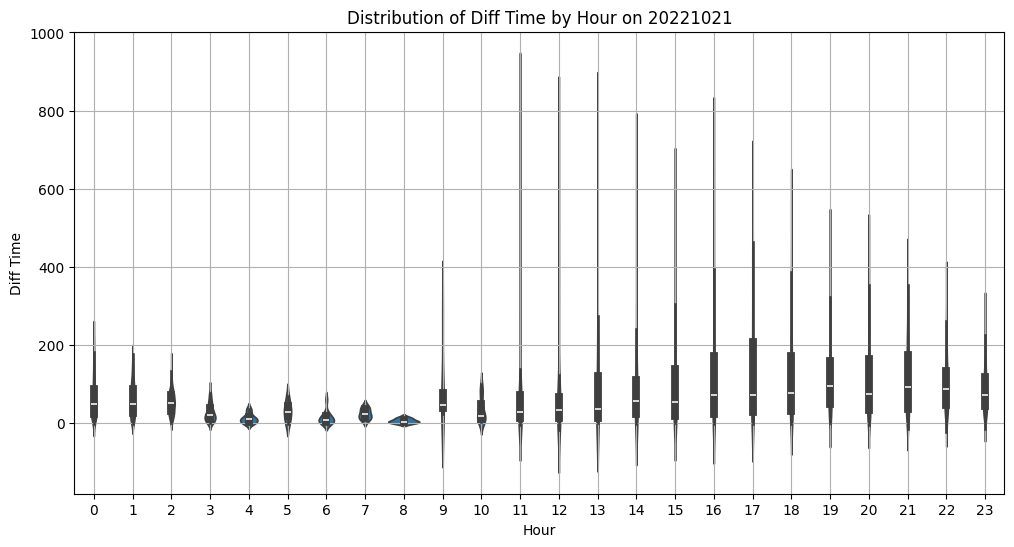

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot for the distribution of diff_time for each hour
plt.figure(figsize=(12, 6))
date  = 20221021
sns.violinplot(x='hour', y='diff_time', data=gdf_start_points_need[gdf_start_points_need['event_date']==date])

# Labels and title
plt.xlabel('Hour')
plt.ylabel('Diff Time')
plt.title(f'Distribution of Diff Time by Hour on {str(date)}')

# Display plot
plt.xticks(range(0, 24))  # Ensure all hours are visible
plt.grid(True)
plt.show()

In [250]:
df_traj_need3 = df_traj_need2[(df_traj_need2['osm_trip_km']!=0)&(df_traj_need2['osm_travel_time_min']!=0)]
print(df_traj_need3.shape[0])
df_traj_need3['diff_dist'] = df_traj_need3['cuebiq_trip_km'] - df_traj_need3['osm_trip_km']
df_traj_need3['diff_time'] = df_traj_need3['cuebiq_travel_time_min'] - df_traj_need3['osm_travel_time_min']

df_traj_need3 = df_traj_need3[(df_traj_need3['diff_dist']<10)&(df_traj_need3['diff_dist']>-10)]
print(df_traj_need3.shape[0])

72047
58946


In [241]:
df_traj_need3['diff_dist'].describe()

count   58946.00000
mean    -0.71899   
std     3.35280    
min     -9.99775   
25%     -2.06356   
50%     -0.39780   
75%     0.38427    
max     9.99893    
Name: diff_dist, dtype: float64

In [242]:
df_traj_need3['diff_time'].describe()

count   58946.00000
mean    63.84311   
std     88.95961   
min     -23.57801  
25%     12.49837   
50%     32.33916   
75%     76.95037   
max     1176.15238 
Name: diff_time, dtype: float64

In [251]:
df_traj_need3['event_date'].unique()

array([20221023, 20221022, 20221021])

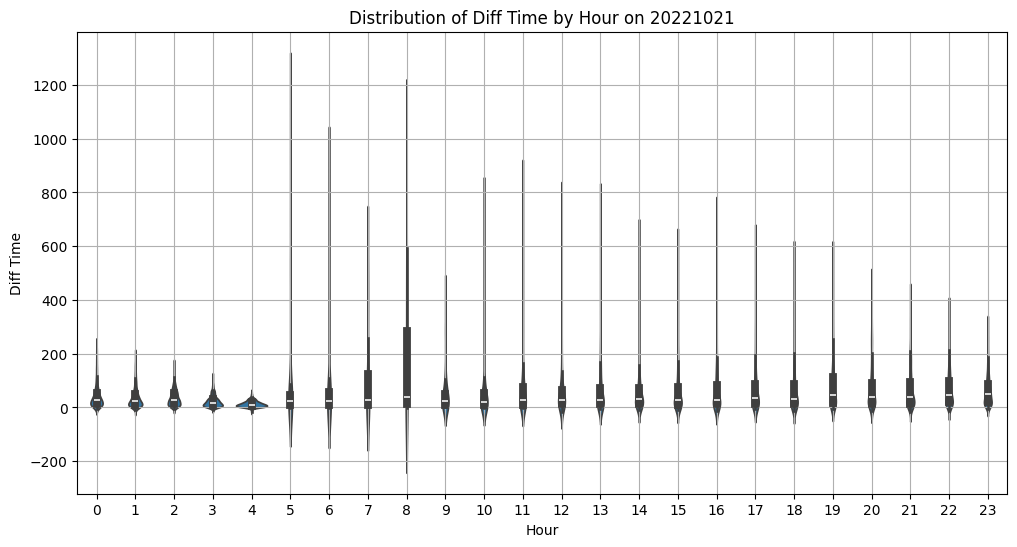

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot for the distribution of diff_time for each hour
plt.figure(figsize=(12, 6))
date  = 20221021
sns.violinplot(x='hour', y='diff_time', data=df_traj_need3[df_traj_need3['event_date']==date])

# Labels and title
plt.xlabel('Hour')
plt.ylabel('Diff Time')
plt.title(f'Distribution of Diff Time by Hour on {str(date)}')

# Display plot
plt.xticks(range(0, 24))  # Ensure all hours are visible
plt.grid(True)
plt.show()

In [73]:
# df_traj_needcol = df_traj_need[['cuebiq_id', 'length_km', 'duration_minutes' ,'trip_distance_km']]
# df_traj_needcol['diff'] = df_traj_needcol['length_km'] - df_traj_needcol['trip_distance_km']
# df_traj_needcol = df_traj_needcol[(df_traj_needcol['diff']<100)&(df_traj_needcol['diff']>-100)]

count   58946.00000
mean    72.69547   
std     91.04409   
min     0.33333    
25%     19.76667   
50%     42.14167   
75%     87.93333   
max     1195.31667 
Name: cuebiq_travel_time_min, dtype: float64
count   58946.00000
mean    8.85236    
std     8.75765    
min     0.00686    
25%     2.15372    
50%     4.73977    
75%     15.44668   
max     86.02074   
Name: osm_travel_time_min, dtype: float64


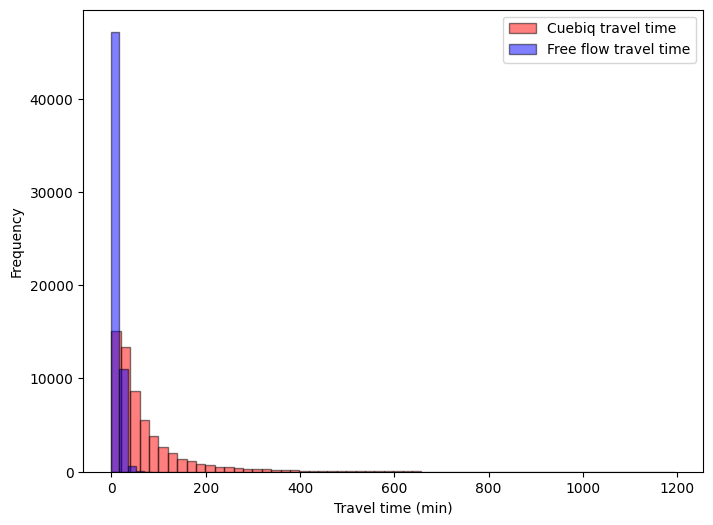

In [257]:
import matplotlib.pyplot as plt

print(df_traj_need3['cuebiq_travel_time_min'].describe())
print(df_traj_need3['osm_travel_time_min'].describe())
# Plot histograms on the same axis
plt.figure(figsize=(8, 6))
plt.hist(df_traj_need3['cuebiq_travel_time_min'], bins=60, alpha=0.5, label='Cuebiq travel time', color='red', edgecolor='black')
plt.hist(df_traj_need3['osm_travel_time_min'], bins=5, alpha=0.5, label='Free flow travel time', color='blue', edgecolor='black')
# Labels and title
plt.xlabel('Travel time (min)')
plt.ylabel('Frequency')
# plt.title('Overlayed Histograms of Trip Distance and Length')
plt.legend()

# Show plot
plt.show()